### Paquetes necesarios

Para asegurar el correcto funcionamiento del notebook, primero importamos todos los paquetes necesarios. Estos incluyen herramientas para procesamiento de imágenes, manejo de archivos, cálculos matemáticos, gestión de rutas y tiempo, así como librerías específicas para detección de objetos y OCR.

In [2]:
import cv2  
import math 
import os
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO
import pandas as pd
import time
import easyocr
import matplotlib.pyplot as plt


### Dataset Splitter

Este script sirve como auxiliar para organizar y dividir el dataset de imágenes de matrículas en conjuntos de entrenamiento, validación y prueba.  

Primero, define las rutas principales: la carpeta donde están las imágenes originales y la carpeta de salida donde se guardará el dataset dividido. También se establecen los porcentajes de división para test y validación, y se define la lista de clases presentes en el dataset, en este caso solo `"matricula"`.  

Se crean automáticamente las subcarpetas necesarias para cada split (`train`, `val`, `test`) y para cada tipo de archivo (`images` y `labels`). Luego, el script obtiene todas las imágenes del dataset original con extensiones válidas (`.jpg`, `.jpeg`, `.png`) y las mezcla aleatoriamente para garantizar que la distribución sea uniforme.  

A continuación, calcula cuántas imágenes corresponden a cada split y organiza las listas de archivos para entrenamiento, validación y prueba. Después, copia cada imagen a su carpeta correspondiente y, si existe, también copia el archivo de etiquetas asociado. Si no se encuentra la etiqueta de alguna imagen, el script muestra un mensaje de advertencia.  

Finalmente, genera un archivo de configuración `data.yaml` que contiene las rutas de los splits, el número de clases y los nombres de las clases. Este archivo es compatible con YOLO y permite entrenar o evaluar el modelo de manera automática.  

Al final, se imprime un resumen con el número total de imágenes, la cantidad de imágenes en cada split y la ubicación de los archivos generados.


In [2]:
# ==== CONFIGURACIÓN ====
dataset_path = Path("Matriculas")

# Carpeta de salida donde se guardará el dataset dividido
output_path = Path("TGC_RBNW")

# Porcentajes
test_ratio = 0.2
val_ratio = 0.25

# Nombre de la clase (puedes cambiarlo si quieres)
class_names = ["matricula"]

# Extensiones de imagen válidas
image_exts = [".jpg", ".jpeg", ".png"]

# ==== CREAR ESTRUCTURA ====
for split in ["train", "val", "test"]:
    for subfolder in ["images", "labels"]:
        os.makedirs(output_path / split / subfolder, exist_ok=True)

# ==== OBTENER IMÁGENES ====
image_files = [f for f in dataset_path.iterdir() if f.suffix.lower() in image_exts]
random.shuffle(image_files)

# ==== DIVISIÓN ====
num_total = len(image_files)
num_test = int(num_total * test_ratio)
num_val = int((num_total - num_test) * val_ratio)
num_train = num_total - num_test - num_val

train_files = image_files[:num_train]
val_files = image_files[num_train:num_train + num_val]
test_files = image_files[num_train + num_val:]

splits = {
    "train": train_files,
    "val": val_files,
    "test": test_files
}

# ==== COPIAR ARCHIVOS ====
for split, files in splits.items():
    for img_path in files:
        label_path = dataset_path / "labels" / f"{img_path.stem}.txt"

        # Copiar imagen
        shutil.copy(img_path, output_path / split / "images" / img_path.name)

        # Copiar etiqueta si existe
        if label_path.exists():
            shutil.copy(label_path, output_path / split / "labels" / label_path.name)
        else:
            print(f"No se encontró etiqueta para {img_path.name}")

# ==== CREAR data.yaml ====
data_config = {
    "train": str((output_path / "train" / "images").resolve()),
    "val": str((output_path / "val" / "images").resolve()),
    "test": str((output_path / "test" / "images").resolve()),
    "nc": len(class_names),
    "names": class_names
}

with open(output_path / "data.yaml", "w") as f:
    yaml.dump(data_config, f, sort_keys=False)

# ==== RESUMEN ====
print("\nDivisión completada correctamente.")
print(f"Total de imágenes: {num_total}")
print(f"Train: {len(train_files)} imágenes")
print(f"Val: {len(val_files)} imágenes")
print(f"Test: {len(test_files)} imágenes")
print(f"Dataset guardado en: {output_path.resolve()}")
print(f"Archivo de configuración generado: {output_path / 'data.yaml'}")


No se encontró etiqueta para 0290KWT_aug2.jpg
No se encontró etiqueta para 4193KRS.jpg
No se encontró etiqueta para C0336BVY_aug4.jpg
No se encontró etiqueta para 4977HNF.jpeg
No se encontró etiqueta para 4981KBP_aug2.jpg
No se encontró etiqueta para 5028HDM_1518_aug3.jpg
No se encontró etiqueta para 0290KWT_8386_aug4.jpg
No se encontró etiqueta para 8453JCX_aug3.jpg
No se encontró etiqueta para SE6207DV_1344_aug3.jpg
No se encontró etiqueta para 4055jtl_aug1.jpg
No se encontró etiqueta para 0576MSH_aug1.jpg
No se encontró etiqueta para 3448LXB_6770_aug5.jpg
No se encontró etiqueta para 6215MTS_aug1.jpg
No se encontró etiqueta para 6099KGF_5595_aug3.jpg
No se encontró etiqueta para 2377JZG_aug4.jpg
No se encontró etiqueta para 7519MHY_7487_aug3.jpg
No se encontró etiqueta para 5601HTN_aug5.jpg
No se encontró etiqueta para 4334NFH_65_aug2.jpg
No se encontró etiqueta para 2724HCW_1343_aug5.jpg
No se encontró etiqueta para 6099KGF_5595_aug5.jpg
No se encontró etiqueta para 5097KBY_4826_au

### Corrección del dataset

Este script se encarga de depurar el dataset para asegurar que solo las imágenes con sus etiquetas correspondientes se utilicen en el entrenamiento del modelo.  

Se define la ruta raíz del dataset y los splits existentes (`train`, `val`, `test`). También se especifican las extensiones de imagen válidas (`.jpg`, `.jpeg`, `.png`).  

Para cada split, el script revisa todas las imágenes y comprueba si existe un archivo de etiqueta asociado en la carpeta de labels. Las imágenes que no tengan su correspondiente archivo de etiqueta se mueven a una subcarpeta llamada `sin_labels`. Esto evita que el modelo reciba datos sin anotaciones durante el entrenamiento, lo que podría afectar negativamente su rendimiento.  

Al finalizar el proceso para cada split, se imprime un resumen indicando cuántas imágenes fueron movidas a la carpeta `sin_labels`.


In [3]:
# ===== CONFIG =====
dataset_root = Path(r"C:\Users\Carlos Ruano\Downloads\VC_P4\TGC_RBNW")
splits = ["train", "val", "test"]
image_exts = [".jpg", ".jpeg", ".png"]

# ===== PROCESO =====
for split in splits:
    images_path = dataset_root / split / "images"
    labels_path = dataset_root / split / "labels"
    sin_labels_path = dataset_root / split / "sin_labels"
    sin_labels_path.mkdir(exist_ok=True)
    image_files = [f for f in images_path.iterdir() if f.suffix.lower() in image_exts]
    moved_count = 0
    for img in image_files:
        label_file = labels_path / f"{img.stem}.txt"
        if not label_file.exists():
            shutil.move(str(img), sin_labels_path / img.name)
            moved_count += 1

    print(f"[{split}] Imágenes movidas a sin_labels: {moved_count}")


[train] Imágenes movidas a sin_labels: 395
[val] Imágenes movidas a sin_labels: 132
[test] Imágenes movidas a sin_labels: 137


### Eliminación de errores en los labels

En algunos archivos de etiquetas (`labels`) se detectó que ciertas clases estaban mal asignadas, usando un `1` en lugar de `0`. Dado que en nuestro proyecto solo nos interesa detectar matrículas, este paso corrige esos errores.  

El script recorre todos los archivos de etiquetas del split de prueba (`test/labels`). Para cada archivo, lee todas las líneas y reemplaza el primer valor de cada línea (que indica la clase del objeto) por `0`. Luego sobrescribe el archivo con las líneas corregidas. Si se desease corregir tambien la parte de train o val solo habria que cambiar la linea del path a la correcta.  

De esta forma, se garantiza que todas las anotaciones correspondan correctamente a la clase de interés, evitando posibles inconsistencias durante la evaluación del modelo.


In [4]:
labels_path = Path(r"TGC_RBNW\test\labels")
for f in labels_path.glob("*.txt"):
    lines = f.read_text().splitlines()
    new_lines = []
    for l in lines:
        if l.strip():
            parts = l.split()
            parts[0] = "0"
            new_lines.append(" ".join(parts))
    f.write_text("\n".join(new_lines))


### Detección de matrícula, desenfoque y reconocimiento de texto

Este bloque realiza la detección de matrículas en un vídeo, aplica un desenfoque sobre ellas y extrae el texto usando OCR. El proceso se divide en varias etapas:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el vídeo de entrada, el vídeo de salida, el archivo CSV donde se guardarán los resultados y el tamaño del kernel de desenfoque.  

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para el reconocimiento de texto en las regiones detectadas.

3. **Procesamiento del vídeo**:  
   Se abre el vídeo de entrada y se obtiene información como el número de fotogramas por segundo y las dimensiones del vídeo. También se prepara un `VideoWriter` para guardar el vídeo resultante.

4. **Creación del CSV**:  
   Se define un DataFrame con columnas que almacenarán información por cada objeto detectado, incluyendo coordenadas, tipo de objeto, confianza, coordenadas de la matrícula y el texto reconocido.

5. **Iteración fotograma a fotograma**:  
   Para cada fotograma del vídeo:
   - Se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado, se extraen las coordenadas y la clase.
   - Si el objeto es una matrícula:
     - Se aplica un padding a la región de interés para que el OCR no corte los bordes.
     - Se convierte a escala de grises y se aplica un umbral adaptativo para mejorar el reconocimiento.
     - Se ejecuta EasyOCR sobre la región, guardando el texto reconocido.
     - Posteriormente, se aplica un desenfoque Gaussiano sobre la matrícula en el fotograma.
   - Se dibujan rectángulos alrededor de todos los objetos detectados, diferenciando visualmente las matrículas.
   - Se almacena toda la información relevante en el DataFrame.

6. **Guardar resultados**:  
   - Se escribe cada fotograma procesado en el vídeo de salida.
   - Al finalizar, se guarda el DataFrame como CSV con toda la información de detección y OCR.

7. **Reporte final**:  
   Se calcula el tiempo promedio de inferencia por fotograma y se imprime un resumen con la ubicación del vídeo procesado y del CSV generado.


In [5]:
# ===== CONFIG =====
model_path = "runs/detect/train/weights/best.pt"
video_input = "Videos/16177622-hd_1920_1080_25fps.mp4"
video_output = "Videos/video_resultado_blur_ocr.mp4"
csv_output = "CSVs/resultados_blur_ocr.csv"
blur_kernel = (25, 25)

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Abrir vídeo =====
cap = cv2.VideoCapture(video_input)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_output, fourcc, fps, (width, height))

# ===== DataFrame para CSV =====
columns = ["fotograma","tipo_objeto","confianza","id_tracking",
           "x1","y1","x2","y2","matricula_en_su_caso",
           "conf_matricula","mx1","my1","mx2","my2","texto_matricula"]
df = pd.DataFrame(columns=columns)

frame_idx = 0
tiempos = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    start_time = time.time()
    results = model(frame)[0]
    tiempos.append(time.time() - start_time)

    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        tipo = model.names[cls_id]

        mx1 = my1 = mx2 = my2 = 0
        conf_matricula = 0
        texto_matricula = ""

        # ===== OCR + Blur en matrículas =====
        if tipo.lower() == "matricula":
            mx1, my1, mx2, my2 = x1, y1, x2, y2

            # Padding para que OCR no corte bordes
            pad = 5
            y1_p, y2_p = max(0, my1-pad), min(frame.shape[0], my2+pad)
            x1_p, x2_p = max(0, mx1-pad), min(frame.shape[1], mx2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            if roi.size != 0:
                # ===== OCR =====
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                ocr_result = reader.readtext(roi_thresh)
                if ocr_result:
                    texto_matricula = " ".join([r[1] for r in ocr_result])
                conf_matricula = conf

                # ===== Aplicar blur después de OCR =====
                roi_blur = cv2.GaussianBlur(roi, blur_kernel, 0)
                frame[y1_p:y2_p, x1_p:x2_p] = roi_blur

        # ===== Dibujar cajas =====
        color = (0,255,0) if tipo.lower() != "matricula" else (0,0,255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{tipo} {conf:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # ===== Guardar info al CSV =====
        df = pd.concat([df, pd.DataFrame([{
            "fotograma": frame_idx,
            "tipo_objeto": tipo,
            "confianza": conf,
            "id_tracking": frame_idx,
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "matricula_en_su_caso": tipo.lower()=="matricula",
            "conf_matricula": conf_matricula,
            "mx1": mx1, "my1": my1, "mx2": mx2, "my2": my2,
            "texto_matricula": texto_matricula
        }])], ignore_index=True)

    # ===== Guardar frame al vídeo de salida =====
    out.write(frame)

# ===== Guardar CSV y liberar recursos =====
df.to_csv(csv_output, index=False)
cap.release()
out.release()
cv2.destroyAllWindows()

# ===== Reporte de inferencia =====
tiempo_promedio = sum(tiempos)/len(tiempos)
print("Procesamiento completado")
print(f"Vídeo guardado en: {video_output}")
print(f"CSV guardado en: {csv_output}")
print(f"Tiempo promedio de inferencia por frame: {tiempo_promedio:.4f} s")



0: 384x640 (no detections), 61.3ms
Speed: 16.1ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.4ms
Speed: 3.7ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.4ms
Speed: 2.9ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 13.5ms
Speed: 4.0ms preprocess, 13.5ms inference, 35.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 13.2ms
Speed: 3.7ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 13.3ms
Speed: 3.7ms preprocess, 13.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


C:\Users\Carlos Ruano\AppData\Local\Temp\ipykernel_7332\624245234.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{



0: 384x640 1 matricula, 12.8ms
Speed: 4.1ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 12.7ms
Speed: 3.6ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 13.6ms
Speed: 4.3ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 matriculas, 13.0ms
Speed: 3.6ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 13.0ms
Speed: 3.4ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 13.0ms
Speed: 4.3ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 12.7ms
Speed: 3.2ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 matriculas, 13.5ms
Speed: 4.1ms preprocess, 13.5ms inference, 2.5ms postproces

### Detección de matrículas y extracción de texto en imágenes de test

Este bloque se encarga de procesar todas las imágenes de la carpeta de test, detectando matrículas, aplicando OCR y generando un CSV con los resultados. El flujo es el siguiente:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el directorio de imágenes de test y el archivo CSV de salida.

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para extraer el texto de las regiones detectadas.

3. **Preparación del CSV**:  
   Se crea un DataFrame vacío con columnas para almacenar el nombre de la imagen, tipo de objeto detectado, confianza, coordenadas de la caja delimitadora y el texto reconocido de la matrícula.

4. **Procesamiento de cada imagen**:  
   - Se recorre cada imagen del directorio de test.
   - Se ignoran archivos que no sean imágenes válidas.
   - Para cada imagen, se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado:
     - Se extraen las coordenadas de la caja y la clase del objeto.
     - Si es una matrícula, se aplica un pequeño padding a la región para mejorar la precisión del OCR.
     - La región de la matrícula se convierte a escala de grises y se aplica un umbral adaptativo.
     - Se ejecuta EasyOCR para extraer el texto de la matrícula.
   - Se guarda toda la información en el DataFrame.

5. **Guardar resultados**:  
   - Al finalizar el procesamiento de todas las imágenes, se exporta el DataFrame completo a un archivo CSV.
   - Se imprime la ubicación del CSV generado para su revisión.


In [6]:
# ===== CONFIG =====
model_path = "runs/detect/train/weights/best.pt"
test_dir = "TGC_RBNW/test/images"
csv_output = "CSVs/matriculas_test.csv"

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Preparar DataFrame =====
columns = ["imagen","tipo_objeto","confianza",
           "x1","y1","x2","y2","texto_matricula"]
df = pd.DataFrame(columns=columns)

# ===== Procesar todas las imágenes =====
for filename in os.listdir(test_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    image_path = os.path.join(test_dir, filename)
    frame = cv2.imread(image_path)
    if frame is None:
        continue

    results = model(frame)[0]

    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        tipo = model.names[cls_id]

        texto_matricula = ""
        if tipo.lower() == "matricula":
            pad = 5
            y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
            x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            if roi.size != 0:
                # OCR
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                ocr_result = reader.readtext(roi_thresh)
                if ocr_result:
                    texto_matricula = " ".join([r[1] for r in ocr_result])

        # Guardar info en DataFrame
        df = pd.concat([df, pd.DataFrame([{
            "imagen": filename,
            "tipo_objeto": tipo,
            "confianza": conf,
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "texto_matricula": texto_matricula
        }])], ignore_index=True)

# ===== Guardar CSV =====
df.to_csv(csv_output, index=False)
print(f"CSV de matrículas generado en: {csv_output}")



0: 640x320 1 matricula, 40.7ms
Speed: 2.8ms preprocess, 40.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 320)

0: 480x640 1 matricula, 48.3ms
Speed: 5.5ms preprocess, 48.3ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


C:\Users\Carlos Ruano\AppData\Local\Temp\ipykernel_7332\3676167963.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{



0: 480x640 1 matricula, 10.9ms
Speed: 2.9ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 matricula, 39.6ms
Speed: 2.6ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 matricula, 14.2ms
Speed: 3.2ms preprocess, 14.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 matricula, 11.9ms
Speed: 3.2ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 matricula, 13.6ms
Speed: 2.8ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 matricula, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 matricula, 12.3ms
Speed: 3.0ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 matriculas, 10.8ms
Speed: 3.4ms preprocess, 10.8ms inference, 1.8ms postprocess per


0: 640x480 1 matricula, 29.6ms
Speed: 6.1ms preprocess, 29.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 480)
[test.jpeg] Texto detectado: LI79HFR


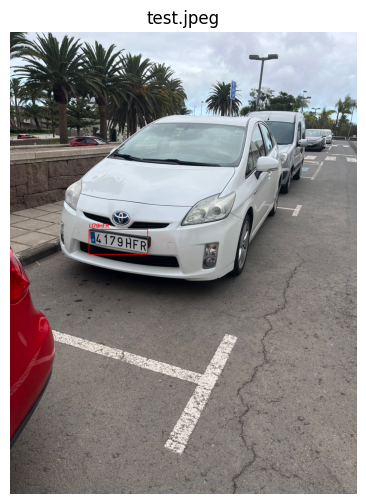


0: 640x480 1 matricula, 16.4ms
Speed: 5.1ms preprocess, 16.4ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 480)
[test2.jpeg] Texto detectado: 4 179HFR


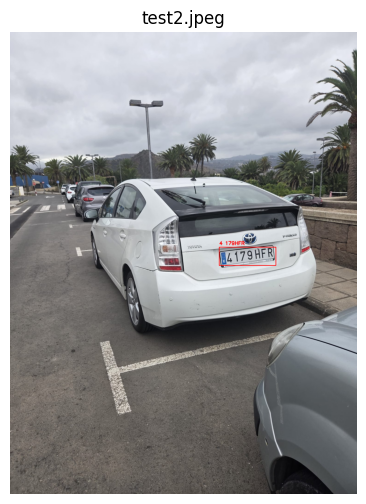

In [5]:
import cv2
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# ===== CONFIG =====
model_path = "runs/detect/train/weights/best.pt"
image_paths = ["test.jpeg", "test2.jpeg"]

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Procesar cada imagen =====
for image_path in image_paths:
    # Cargar imagen
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"No se pudo cargar la imagen {image_path}")
        continue

    # Detección
    results = model(frame)[0]

    # Procesar detecciones
    for box in results.boxes:
        cls_id = int(box.cls[0])
        tipo = model.names[cls_id]
        if tipo.lower() == "matricula":
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Padding
            pad = 5
            y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
            x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            # OCR
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            ocr_result = reader.readtext(roi_thresh)
            texto_matricula = " ".join([r[1] for r in ocr_result]) if ocr_result else ""
            print(f"[{image_path}] Texto detectado:", texto_matricula)

            # Dibujar recuadro
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2)
            cv2.putText(frame, texto_matricula, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Mostrar imagen con matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.title(image_path)
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
